In [1]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd

import sys
import os

from Tarjet import Tarjet

from Phisicsparams import PhysicsParams
from utils import *
from MTMM import *
from tqdm import tqdm

from multiresglonet import GLOnet
from material_database import MatDatabase

In [2]:
params = Params()

In [3]:
params.thickness_sup = 0.2
params.N_layers = 40
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.00
  params.n_max = 2.5
  params.M_discretion_n = 300
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en funcion de los parametros fisicos (physics_params)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup = 20
params.numIter = 200
params.sigma = 0.045
params.batch_size = 200
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 20                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 512                                                                              # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 20                                                                              # Dimension de la Capa de entrada
params.lr = 0.043                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


In [4]:
params.condiciones = 3
physicsparams = PhysicsParams(params.condiciones, user_define=True)

n_interna = 1.2

physicsparams.n_bot_1 = n_interna
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 45
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "TE"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = n_interna
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.n_bot_3 = 1
physicsparams.n_top_3 = n_interna
physicsparams.k_3 = 400
physicsparams.k_values.append(physicsparams.k_3)
physicsparams.theta_3 = 0
physicsparams.lambda_min_3 = 380
physicsparams.lambda_max_3 = 495
physicsparams.pol_3 = "TE"


physicsparams.generate_physics_params()
physicsparams.view_attributes()

tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()

if not params.user_define:
    params.matdatabase =  MatDatabase(params.materials)
    params.n_database = params.matdatabase.interp_wv(2 * math.pi/physicsparams.ks, params.materials, True)
    params.M_materials =  params.n_database.size(0)
else:
    pass


user_define: True
k_values: [370, 190, 400]
n_bot_1: tensor([1.2000])
n_top_1: tensor([1])
k_1: tensor([16.5347, 16.4912, 16.4479, 16.4048, 16.3620, 16.3194, 16.2770, 16.2348,
        16.1929, 16.1511, 16.1096, 16.0683, 16.0272, 15.9863, 15.9456, 15.9052,
        15.8649, 15.8248, 15.7850, 15.7453, 15.7058, 15.6666, 15.6275, 15.5886,
        15.5499, 15.5114, 15.4731, 15.4350, 15.3971, 15.3594, 15.3218, 15.2844,
        15.2472, 15.2102, 15.1734, 15.1367, 15.1003, 15.0640, 15.0278, 14.9919,
        14.9561, 14.9205, 14.8851, 14.8498, 14.8147, 14.7797, 14.7449, 14.7103,
        14.6759, 14.6416, 14.6075, 14.5735, 14.5397, 14.5060, 14.4725, 14.4392,
        14.4060, 14.3729, 14.3400, 14.3073, 14.2747, 14.2422, 14.2100, 14.1778,
        14.1458, 14.1139, 14.0822, 14.0506, 14.0192, 13.9879, 13.9568, 13.9257,
        13.8949, 13.8641, 13.8335, 13.8030, 13.7727, 13.7425, 13.7124, 13.6825,
        13.6527, 13.6230, 13.5934, 13.5640, 13.5347, 13.5055, 13.4765, 13.4476,
        13.4188, 13.3901

In [5]:
tarjet.tarjets_transmisions["tarjet_1"].view(-1)[0:190 ] = 1
tarjet.tarjets_reflections["tarjet_1"].view(-1)[190:] = 1

tarjet.tarjets_transmisions["tarjet_2"].view(-1)[0:115 ] = 1
tarjet.tarjets_reflections["tarjet_2"].view(-1)[115:] = 1

tarjet.tarjets_transmisions["tarjet_3"].view(-1)[:] = 1
tarjet.tarjets_reflections["tarjet_3"].view(-1)[:] = 0

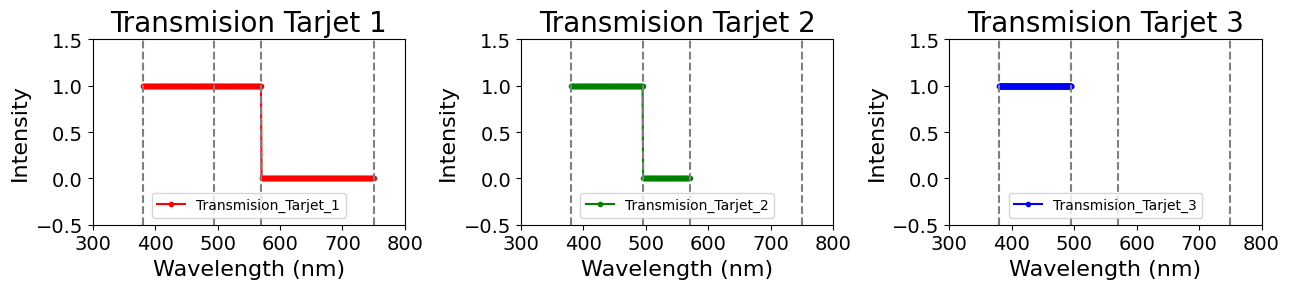

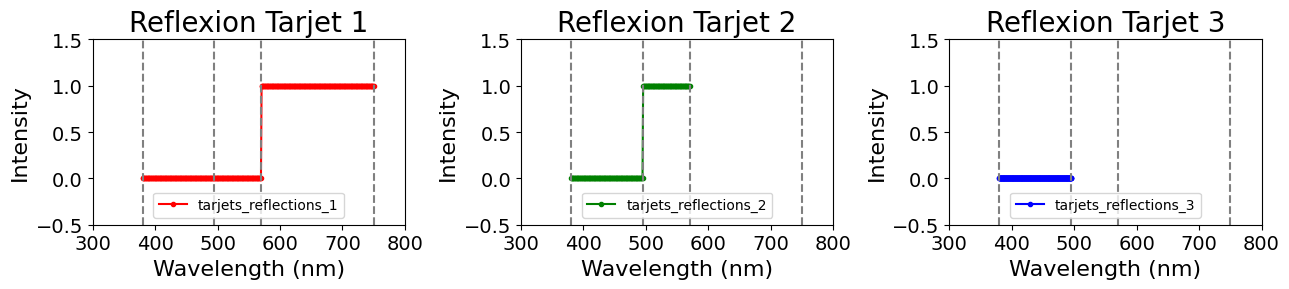

In [6]:
# Subplots para Transmisiones
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 1 fila, 3 columnas
fig.subplots_adjust(wspace=0.4)
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(2*math.pi / physicsparams.k_1 * 1000, tarjet.tarjets_transmisions["tarjet_1"].view(-1), ".-", color="red", label="Transmision_Tarjet_1")
        ax.set_title("Transmision Tarjet 1", fontsize=20)
    elif i == 1:
        ax.plot(2*math.pi / physicsparams.k_2 * 1000, tarjet.tarjets_transmisions["tarjet_2"].view(-1), ".-", color="green", label="Transmision_Tarjet_2")
        ax.set_title("Transmision Tarjet 2", fontsize=20)
    elif i == 2:
        ax.plot(2*math.pi / physicsparams.k_3 * 1000, tarjet.tarjets_transmisions["tarjet_3"].view(-1), ".-", color="blue", label="Transmision_Tarjet_3")
        ax.set_title("Transmision Tarjet 3", fontsize=20)

    ax.set_xlabel("Wavelength (nm)", fontsize=16)
    ax.set_ylabel("Intensity", fontsize=16)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Agregar líneas verticales punteadas
    for line_pos in vertical_lines:
        ax.axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de transmisiones
plt.show()

# Subplots para Reflexiones
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 1 fila, 3 columnas
fig.subplots_adjust(wspace=0.4)
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(2*math.pi / physicsparams.k_1 * 1000, tarjet.tarjets_reflections["tarjet_1"].view(-1), ".-", color="red", label="tarjets_reflections_1")
        ax.set_title("Reflexion Tarjet 1", fontsize=20)
    elif i == 1:
        ax.plot(2*math.pi / physicsparams.k_2 * 1000, tarjet.tarjets_reflections["tarjet_2"].view(-1), ".-", color="green", label="tarjets_reflections_2")
        ax.set_title("Reflexion Tarjet 2", fontsize=20)
    elif i == 2:
        ax.plot(2*math.pi / physicsparams.k_3 * 1000, tarjet.tarjets_reflections["tarjet_3"].view(-1), ".-", color="blue", label="tarjets_reflections_3")
        ax.set_title("Reflexion Tarjet 3", fontsize=20)

    ax.set_xlabel("Wavelength (nm)", fontsize=16)
    ax.set_ylabel("Intensity", fontsize=16)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Agregar líneas verticales punteadas
    for line_pos in vertical_lines:
        ax.axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()

100%|██████████| 200/200 [25:48<00:00,  7.74s/it]


iteration1


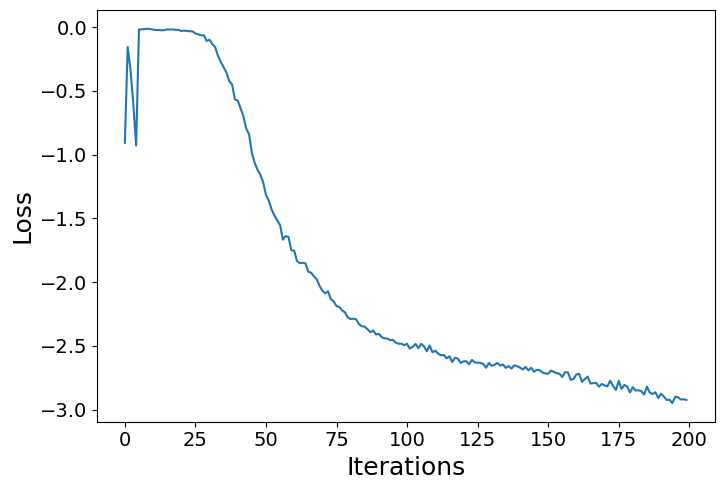

In [7]:
for seed in range(1):                                                # Generacion del comando for para las semillas (0, ->(cantidad de semillas aleatorias), 1)
  params.seed = seed

  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  glonet.viz_training()
  print(f"iteration{seed + 1}")
  

Espesores: tensor([0.0869, 0.0979, 0.1533, 0.0769, 0.0530, 0.1397, 0.1703, 0.1678, 0.1911,
        0.1144, 0.1939, 0.1041, 0.1668, 0.1945, 0.1619, 0.1526, 0.1269, 0.1903,
        0.1142, 0.1828, 0.0607, 0.1883, 0.0849, 0.1543, 0.0831, 0.1703, 0.0822,
        0.1445, 0.0881, 0.1292, 0.0919, 0.1259, 0.1009, 0.1555, 0.0732, 0.0787,
        0.1938, 0.1180, 0.1349, 0.0998])
Indices de refraccion tensor([[1.2910],
        [1.4214],
        [1.4866],
        [1.5418],
        [1.7525],
        [1.7475],
        [1.9181],
        [2.0435],
        [2.0786],
        [1.8729],
        [2.1990],
        [2.0033],
        [2.1237],
        [2.1589],
        [2.0084],
        [1.9231],
        [1.9084],
        [2.2592],
        [1.9632],
        [2.0936],
        [1.8829],
        [1.8077],
        [2.4247],
        [1.2759],
        [2.4097],
        [1.2007],
        [2.4097],
        [1.3161],
        [2.2441],
        [1.4013],
        [2.1990],
        [1.1455],
        [1.8829],
        [1.1

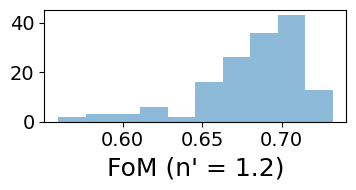

In [8]:
with torch.no_grad():
  params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
  params.theta_test = torch.linspace(0, math.pi/2.25, 50)
  (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector = params.k_test,  inc_angles = params.theta_test, grayscale=True)
  reflex, transmix = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)
  for i in range(1, physicsparams.condiciones):
      reflex_key = f'reflexion_{i}'
      tarjet_key = f'tarjet_{i}'
      r = reflex[reflex_key]
      FoM_reflex = torch.pow(r - tarjet.tarjets_reflections[tarjet_key], 2).mean(dim=[1, 2, 3])  
  for i in range(1, physicsparams.condiciones):
      transmision_key = f'transmision_{i}'
      tarjet_key = f'tarjet_{i}'
      t = transmix[transmision_key]
      FoM_transmix = torch.pow(t - tarjet.tarjets_transmisions[tarjet_key], 2).mean(dim=[1, 2, 3])

  FoM_total =  FoM_reflex + FoM_transmix
  plt.figure(figsize = (10, 2))
  plt.subplot(131)
  plt.hist(FoM_total.cpu().detach().numpy(), alpha = 0.5)
  plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

_, indices = torch.sort(FoM_total)
opt_idx = indices[0]

optimal_thicknesses = thicknesses[opt_idx]
optimal_ref_idx = ref_index[opt_idx]

print("Espesores:" , optimal_thicknesses)
print("Indices de refraccion",optimal_ref_idx)

optimal_reflections = {}
optimal_transmisions = {}

for i in range(1, params.condiciones + 1):
    reflex_key = f'reflexion_{i}'
    optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
        
for i in range(1, params.condiciones + 1):
    transmision_key = f'transmision_{i}'
    optimal_transmisions[transmision_key] = transmix[transmision_key][opt_idx]

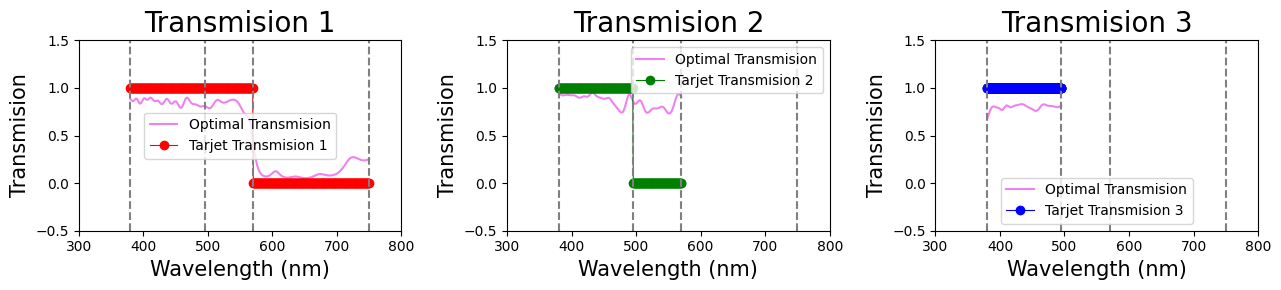

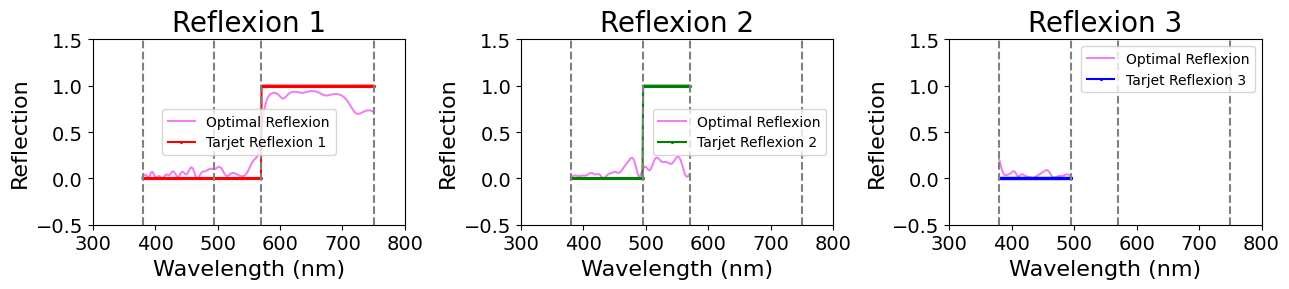

Espesores: tensor([0.0869, 0.0979, 0.1533, 0.0769, 0.0530, 0.1397, 0.1703, 0.1678, 0.1911,
        0.1144, 0.1939, 0.1041, 0.1668, 0.1945, 0.1619, 0.1526, 0.1269, 0.1903,
        0.1142, 0.1828, 0.0607, 0.1883, 0.0849, 0.1543, 0.0831, 0.1703, 0.0822,
        0.1445, 0.0881, 0.1292, 0.0919, 0.1259, 0.1009, 0.1555, 0.0732, 0.0787,
        0.1938, 0.1180, 0.1349, 0.0998])
Indices de refraccion: tensor([1.2910, 1.4214, 1.4866, 1.5418, 1.7525, 1.7475, 1.9181, 2.0435, 2.0786,
        1.8729, 2.1990, 2.0033, 2.1237, 2.1589, 2.0084, 1.9231, 1.9084, 2.2592,
        1.9632, 2.0936, 1.8829, 1.8077, 2.4247, 1.2759, 2.4097, 1.2007, 2.4097,
        1.3161, 2.2441, 1.4013, 2.1990, 1.1455, 1.8829, 1.1957, 1.5769, 1.8027,
        1.6472, 1.4264, 1.7023, 1.2609], dtype=torch.float64)


In [9]:


xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 1 fila, 3 columnas
fig.subplots_adjust(wspace=0.4)

for i in range(1, 4):
    # Gráfico de transmisión óptima
    axs[i-1].plot(2*math.pi / getattr(physicsparams, f'k_{i}') * 1000, optimal_transmisions[f'transmision_{i}'][:,0,0].detach().numpy(), "-", color="violet", label="Optimal Transmision")
    
    # Gráfico de transmisión de tarjeta
    if i == 1:
        tarjet_color = "red"
    elif i == 2:
        tarjet_color = "green"
    elif i == 3:
        tarjet_color = "blue"
    
    axs[i-1].plot(2*math.pi / getattr(physicsparams, f'k_{i}') * 1000, tarjet.tarjets_transmisions[f"tarjet_{i}"].view(-1), "-o", color=tarjet_color, label=f"Tarjet Transmision {i}", linewidth=0.8)
    
    axs[i-1].set_xlabel("Wavelength (nm)", fontsize=15)
    axs[i-1].set_ylabel("Transmision", fontsize=15)
    axs[i-1].legend(loc="best")
    axs[i-1].set_title(f"Transmision {i}", fontsize=20)
    
    # Establecer límites y agregar líneas verticales punteadas para transmisiones
    axs[i-1].set_xlim(xlim)
    axs[i-1].set_ylim(ylim)
    
    for line_pos in vertical_lines:
        axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de transmisiones
plt.show()

# Subplots para Reflexiones
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 1 fila, 3 columnas
fig.subplots_adjust(wspace=0.4)

# Loop sobre los índices 1, 2, 3 para los subplots de reflexiones
for i in range(1, 4):
    # Gráfico de reflexión óptima
    axs[i-1].plot(2*math.pi / getattr(physicsparams, f'k_{i}') * 1000, optimal_reflections[f'reflexion_{i}'][:,0,0].detach().numpy(), "-", color="violet", label="Optimal Reflexion")
    
    # Gráfico de reflexión de tarjeta
    if i == 1:
        tarjet_color = "red"
    elif i == 2:
        tarjet_color = "green"
    elif i == 3:
        tarjet_color = "blue"
    
    axs[i-1].plot(2*math.pi / getattr(physicsparams, f'k_{i}') * 1000, tarjet.tarjets_reflections[f"tarjet_{i}"].view(-1), ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)
    
    axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
    axs[i-1].set_ylabel("Reflection", fontsize=16)
    axs[i-1].legend(fontsize=10)
    axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
    axs[i-1].tick_params(axis='both', which='major', labelsize=14)
    axs[i-1].set_xlim(xlim)
    axs[i-1].set_ylim(ylim)

    # Agregar líneas verticales punteadas para reflexiones
    for line_pos in vertical_lines:
        axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')


# Mostrar la figura de reflexiones
plt.show()
print("Espesores:" , optimal_thicknesses.view(-1))
print("Indices de refraccion:",optimal_ref_idx.view(-1))

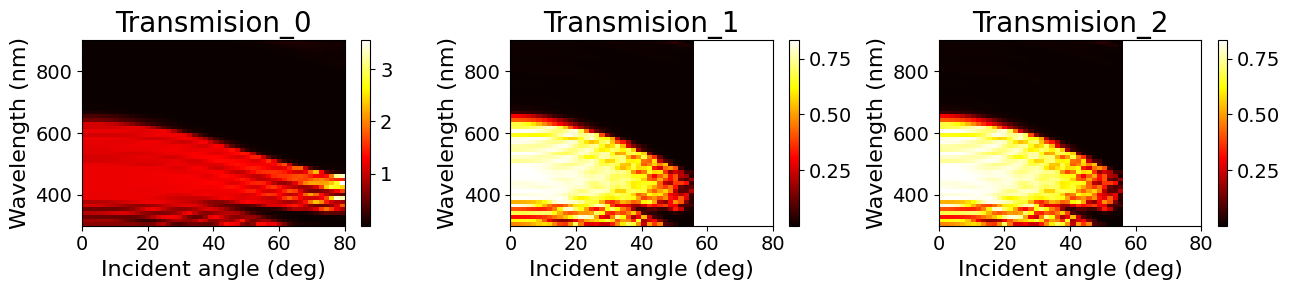

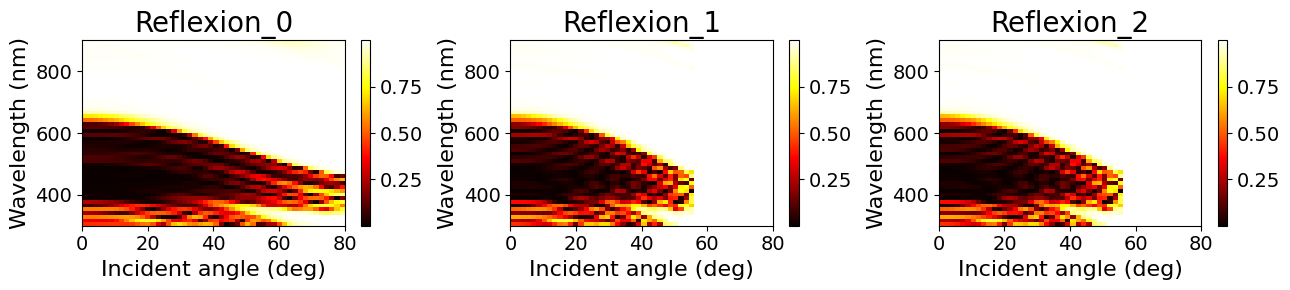

In [10]:

(thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector = params.k_test,  inc_angles = params.theta_test, grayscale=True)
r = []
t = []
params.k_test = 2 * math.pi / torch.linspace(0.3, 0.9, 50)
params.theta_test = torch.linspace(0, math.pi/2.25, 50)

for i in range(3):  
    r_ , t_= TMM_solver(thicknesses , 
                            ref_index, 
                            getattr(physicsparams, f'n_top_{i + 1}'), 
                            getattr(physicsparams, f'n_bot_{i + 1}'),
                            params.k_test,
                            params.theta_test)
    r.append(r_)
    t.append(t_)

_ ,  index = torch.sort(FoM_total)
opt_inx =  index[0]


fig, axs = plt.subplots(1,3, figsize=(13, 3))
fig.subplots_adjust(wspace=0.4)
for i in range(3):
    im1 = axs[i].imshow(t[i][opt_inx, : , 0, :].detach().cpu().numpy(), origin='lower', aspect='auto', cmap='hot', extent=[0, 80, 300, 900])
    cbar1 = fig.colorbar(im1, ax=axs[i])
    cbar1.ax.tick_params(labelsize=14)
    axs[i].set_title(f'Transmision_{i}', fontsize=20)
    axs[i].set_xlabel('Incident angle (deg)', fontsize=16)
    axs[i].set_ylabel('Wavelength (nm)', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

fig, axs = plt.subplots(1,3, figsize=(13, 3))
fig.subplots_adjust(wspace=0.4)
for i in range(3):
    im1 = axs[i].imshow(r[i][opt_inx, : , 0, :].detach().cpu().numpy(), origin='lower', aspect='auto', cmap='hot', extent=[0, 80, 300, 900])
    cbar1 = fig.colorbar(im1, ax=axs[i])
    cbar1.ax.tick_params(labelsize=14)
    axs[i].set_title(f'Reflexion_{i}', fontsize=20)
    axs[i].set_xlabel('Incident angle (deg)', fontsize=16)
    axs[i].set_ylabel('Wavelength (nm)', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    

# Vista que valor le doy a n_interna


Reviso N interna en entrenamientos cortos para revisar el error minimo de la funcion

In [18]:
params.thickness_sup = 0.2
params.N_layers = 40
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.00
  params.n_max = 2.5
  params.M_discretion_n = 300
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en funcion de los parametros fisicos (physics_params)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup = 20
params.numIter = 50
params.sigma = 0.055
params.batch_size = 20
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 20                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 512                                                                              # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 20                                                                              # Dimension de la Capa de entrada
params.lr = 0.043                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


iteration1
 n` = 1.01


100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


iteration2
 n` = 1.0125


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


iteration3
 n` = 1.015


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


iteration4
 n` = 1.0175


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


iteration5
 n` = 1.02


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


iteration6
 n` = 1.0225


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


iteration7
 n` = 1.025


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


iteration8
 n` = 1.0275


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


iteration9
 n` = 1.03


100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


iteration10
 n` = 1.0325


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


iteration11
 n` = 1.035


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


iteration12
 n` = 1.0375


100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


iteration13
 n` = 1.04


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


iteration14
 n` = 1.0425


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


iteration15
 n` = 1.045


100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


iteration16
 n` = 1.0475


100%|██████████| 50/50 [02:55<00:00,  3.50s/it]


iteration17
 n` = 1.05


100%|██████████| 50/50 [02:26<00:00,  2.92s/it]


iteration18
 n` = 1.0525


100%|██████████| 50/50 [03:57<00:00,  4.75s/it]


iteration19
 n` = 1.055


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


iteration20
 n` = 1.0575


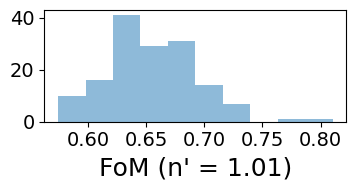

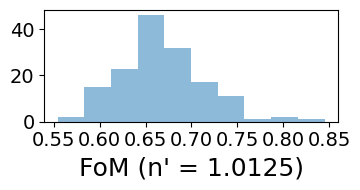

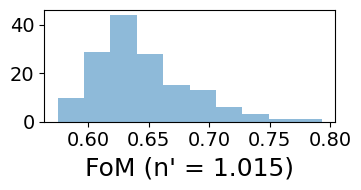

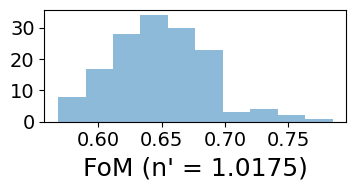

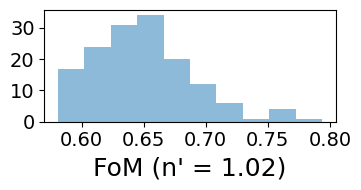

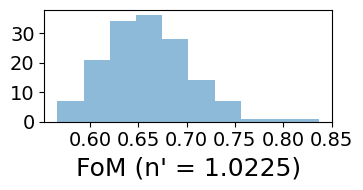

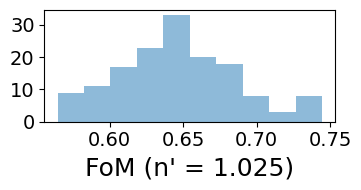

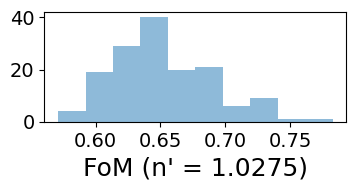

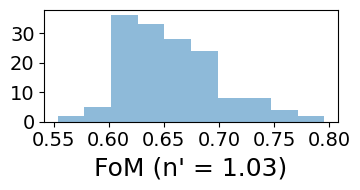

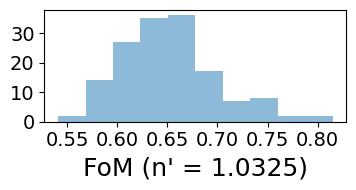

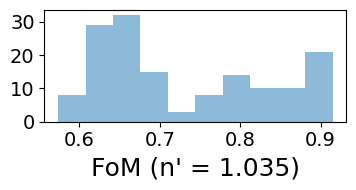

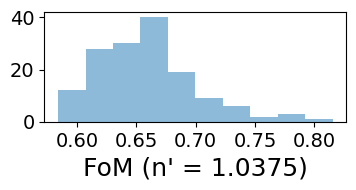

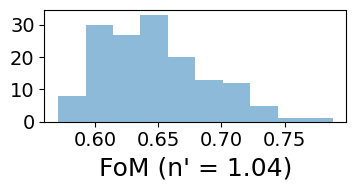

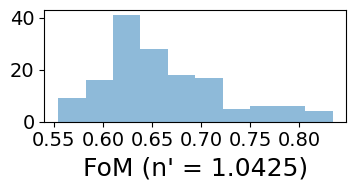

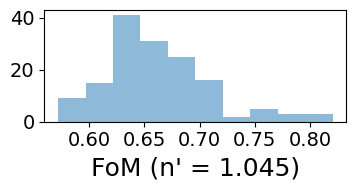

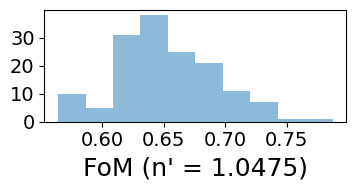

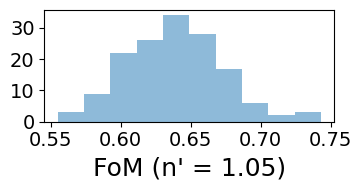

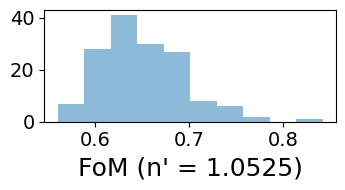

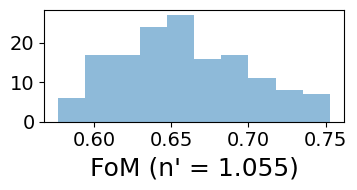

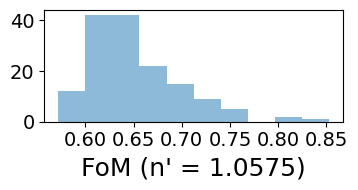

In [19]:

for n_value in range(20):
  
  n_interna = 1.01 + 0.05 * n_value / 20
  
  physicsparams.n_bot_1 = n_interna
  physicsparams.n_top_1 = 1
  physicsparams.k_1 = 370
  physicsparams.k_values.append(physicsparams.k_1)
  physicsparams.theta_1 = 45
  physicsparams.lambda_min_1 = 380
  physicsparams.lambda_max_1 = 750
  physicsparams.pol_1 = "TE"
  
  physicsparams.n_bot_2 = 1
  physicsparams.n_top_2 = n_interna
  physicsparams.k_2 = 190
  physicsparams.k_values.append(physicsparams.k_2)
  physicsparams.theta_2 = 45
  physicsparams.lambda_min_2 = 380
  physicsparams.lambda_max_2 = 570
  physicsparams.pol_2 = "TE"
  
  physicsparams.n_bot_3 = 1
  physicsparams.n_top_3 = n_interna
  physicsparams.k_3 = 400
  physicsparams.k_values.append(physicsparams.k_3)
  physicsparams.theta_3 = 0
  physicsparams.lambda_min_3 = 380
  physicsparams.lambda_max_3 = 495
  physicsparams.pol_3 = "TE"
  
  
  physicsparams.generate_physics_params()
  
  tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
  tarjet.configure_targets()

  params.seed = n_value
  

  torch.manual_seed(n_value)
  
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  # glonet.viz_training()
  print(f"iteration{n_value + 1 }")
  print(f" n` = {n_interna}")

  with torch.no_grad():
    params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
    params.theta_test = torch.linspace(0, math.pi/2.25, 50)
    (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector = params.k_test,  inc_angles = params.theta_test, grayscale=True)
    reflex, transmix = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)
    for i in range(1, physicsparams.condiciones):
        reflex_key = f'reflexion_{i}'
        tarjet_key = f'tarjet_{i}'
        r = reflex[reflex_key]
        FoM_reflex = torch.pow(r - tarjet.tarjets_reflections[tarjet_key], 2).mean(dim=[1, 2, 3])  
    for i in range(1, physicsparams.condiciones):
        transmision_key = f'transmision_{i}'
        tarjet_key = f'tarjet_{i}'
        t = transmix[transmision_key]
        FoM_transmix = torch.pow(t - tarjet.tarjets_transmisions[tarjet_key], 2).mean(dim=[1, 2, 3])

    FoM_total =  FoM_reflex + FoM_transmix
    plt.figure(figsize = (10, 2))
    plt.subplot(131)
    plt.hist(FoM_total.cpu().detach().numpy(), alpha = 0.5)
    plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


